In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
import tcripser
import gudhi,gudhi.hera,gudhi.wasserstein,persim
import ase
from ase.io import cube
from ase.io import cif
import multiprocessing
from multiprocessing.dummy import Pool
import pickle
import json

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import torch
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
from typing import *
import collections
import itertools

In [4]:
inDir="Z:/data/diverse_metals"
df=pd.read_csv(f"{inDir}/post-combustion-vsa-2-clean.csv",index_col=0)
phDF=pd.read_csv(f"{inDir}/phDF_tThresh0_B1.csv",index_col=0)
imgIndexOrd=list(phDF.index)

In [6]:
newThresh=[-8,25]
pBounds=[-25,50]

truncCols=[i for i in phDF.columns[4:] if newThresh[0]<=int(i.split("_")[0])<=newThresh[1] and newThresh[0]<=int(i.split("_")[1])<=newThresh[1]]

phDFSub=phDF[list(phDF.columns[:4])+list(truncCols)]

In [6]:
class CubePHDataset(torch.utils.data.Dataset):
    def __init__(self, property_excel_dir: str, phDF_dir: str,cifs: List[str] = None ,newThresh: List[int]=None,elimDiag=True ):

        if property_excel_dir[-3:]=="csv": #better for match: case if python > 3.10
            propertyDF: pd.DataFrame = pd.read_csv(property_excel_dir,index_col=0)
        elif property_excel_dir[-4:]=="xlsx":
            propertyDF: pd.DataFrame = pd.read_excel(property_excel_dir,index_col=0)
        if phDF_dir[-3:]=="csv":
            phDF: pd.DataFrame = pd.read_csv(phDF_dir,index_col=0) #indexIsMOFs
        elif phDF_dir[-4:]=="xlsx":
            phDF: pd.DataFrame = pd.read_excel(phDF_dir,index_col=0) #indexIsMOFs
        if cifs: ## You can either provide the general phDF + property_excel files, and a list of subset cifs
            assert False not in {c in (set(phDF.index) & set(propertyDF.index)) for c in cifs}
            self.cifs=cifs
        else: ### or you can leave cifs as none and just take all overlapping MOFS in both input data files
            self.cifs=list(set(phDF.index) & set(propertyDF.index)) #
        self.property=torch.from_numpy((propertyDF.loc[self.cifs]).to_numpy(dtype=np.float32))
        self.propCols=list(propertyDF.columns)

        phDF=phDF.loc[self.cifs]

        phVals={int(s[:s.find("_")]) for s in phDF.columns if "_" in s}# assuming integer resolution for now
        # this requires the columns to have the format b_d
        phBounds=[min(phVals),max(phVals)]
        self.phThresh=phBounds
        if newThresh and len(newThresh)==2 and newThresh[0]>=self.phThresh[0] and  newThresh[1]<=self.phThresh[1] :
            self.subsetPHImg(phDF,newThresh)
        else:
            self.subsetPHImg(phDF,self.phThresh)

        if elimDiag:
            self.elimDiag()



    def subsetPHImg(self,phDF,newThresh: List[int]=[-8, 25],offset=4):

        truncCols=[i for i in phDF.columns[offset:] if newThresh[0]<=int(i.split("_")[0])<=newThresh[1] and newThresh[0]<=int(i.split("_")[1])<=newThresh[1]]
        phDFSub=phDF[list(phDF.columns[:offset])+list(truncCols)]
        life=newThresh[1]-newThresh[0]

        phImg=np.zeros((len(self.cifs),life+1,life+1))#,dtype='uint8')

        for m in range(len(self.cifs)):
            for b in np.arange(newThresh[0],newThresh[1]+1):
                for d in np.arange(b,newThresh[1]+1):
                    phImg[m,newThresh[1]-d,b-newThresh[0]]=phDFSub[f"{b}_{d}"].loc[self.cifs[m]]
        self.phThresh=newThresh
        self.phImg=torch.from_numpy(phImg).type(torch.float32)


    def elimDiag(self): #allow persist thresh in future but really fast implementation for one pixel
        sqlen=len(self.phImg[0])
        imgClone=self.phImg.clone()
        yrange=torch.arange(sqlen)
        imgClone[:,yrange.__reversed__(),yrange]=torch.tensor(0).to(imgClone)
        self.phImg=imgClone

    def __len__(self):
        return len(self.cifs)

    def __getitem__(self, index):
        return {"cif":self.cifs[index],
                "image": self.phImg[index],
                "workcap": self.property[index][0].view(1,),
                "sel": self.property[index][1].view(1,),
                }


In [17]:
dataset = CubePHDataset(property_excel_dir=f"{inDir}/post-combustion-vsa-2-clean.csv",
                        phDF_dir=f"{inDir}/phDF_tThresh0_B1.csv", newThresh=[-8,25])


KeyboardInterrupt: 

In [29]:
MLinDir=f"{inDir}/dataSplitML"
optVar="sel"

trainDataset=CubePHDataset(property_excel_dir=f"{MLinDir}/{optVar}/trainCombustionDiverseMOF.xlsx",
                        phDF_dir=f"{inDir}/phDF_tThresh0_B1.csv", newThresh=[-8,23])

In [23]:
trainDataset[5000]

{'cif': 'DB12-DADLIG_freeONLY',
 'image': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'workcap': tensor([1.1375]),
 'sel': tensor([278.5536])}

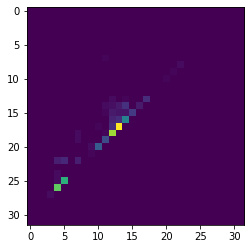

In [31]:
plt.imshow(trainDataset[5000]['image'])

In [32]:
trainDataset[5000]['image'].shape

torch.Size([32, 32])

In [7]:
def collate_fn(batch):
    #print(batch)
    #pd, image, cif = batch['pd'], batch['image'], batch['cif']
    elem = batch[0]
    assert isinstance(elem, collections.abc.Mapping)
    #print(type(batch))

    mapped_dict = {key: torch.stack([d[key] for d in batch], dim=0) for key in elem if key in ['pd', 'image', 'workcap', 'sel'] }
    mapped_dict.update({key: [d[key] for d in batch] for key in elem if key not in ['pd', 'image', 'workcap', 'sel']})
    #print(mapped_dict.keys())

    image, cif, workcap, sel = mapped_dict['image'], mapped_dict['cif'], mapped_dict['workcap'], mapped_dict['sel']

    return dict(image=image[:,None,...], cif=cif, workcap=workcap, sel=sel)


In [49]:
torch.manual_seed(42)

MLinDir=f"{inDir}/dataSplitML"
optVar="sel"

trainDataset=CubePHDataset(property_excel_dir=f"{MLinDir}/{optVar}/trainCombustionDiverseMOF.xlsx",
                        phDF_dir=f"{inDir}/phDF_tThresh0_B1.csv", newThresh=[-8,23])

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=2048, pin_memory=True, num_workers=0, shuffle=True,collate_fn=collate_fn)

testDataset=CubePHDataset(property_excel_dir=f"{MLinDir}/{optVar}/testCombustionDiverseMOF.xlsx",
                        phDF_dir=f"{inDir}/phDF_tThresh0_B1.csv", newThresh=[-8,23])
test_dataloader= torch.utils.data.DataLoader(testDataset, batch_size=1024, pin_memory=True, num_workers=0, shuffle=False,collate_fn=collate_fn)

validDataset=CubePHDataset(property_excel_dir=f"{MLinDir}/{optVar}/valCombustionDiverseMOF.xlsx",
                        phDF_dir=f"{inDir}/phDF_tThresh0_B1.csv", newThresh=[-8,23])
valid_dataloader= torch.utils.data.DataLoader(validDataset, batch_size=1024, pin_memory=True, num_workers=0, shuffle=False,collate_fn=collate_fn)


In [27]:
data = next(iter(train_dataloader))
data

{'cif': ['DB0-m3_o16_o43_f0_fsc.sym.17',
  'DB5-hypotheticalMOF_35577_0_0_2_14_2_10',
  'DB0-m3_o10_o16_f0_pcu.sym.3',
  'DB15-pcu_N123_E156_opt',
  'DB0-m23_o151_o153_f0_pcu',
  'DB14-vapfup_P1_H',
  'DB0-m3_o16_o22_f0_pcu.sym.122',
  'DB0-m2_o10_o25_f0_pcu.sym.93',
  'DB0-m3_o10_o29_f0_pcu.sym.40',
  'DB12-JEJKEP_clean',
  'DB12-EXOZEX_freeONLY',
  'DB5-hypotheticalMOF_5072577_1_0_2_19_5_6',
  'DB0-m2_o11_o12_f0_pcu.sym.73',
  'DB7-ddmof_21169',
  'DB0-m3_o14_o27_f0_pcu.sym.104',
  'DB12-EPEXII_freeONLY',
  'DB12-HALVAU_clean',
  'DB0-m3_o24_o520_f0_fsc.sym.40',
  'DB0-m3_o12_o25_f0_pcu.sym.46',
  'DB12-HEMTEZ_clean',
  'DB0-m3_o12_o26_f0_pcu.sym.76',
  'DB1-Zn2O8N2-AZO_A-irmof10_A_No325',
  'DB0-m3_o12_o23_f0_pcu.sym.129',
  'DB0-m2_o12_o20_f0_pcu.sym.24',
  'DB12-EBATUY_freeONLY',
  'DB15-pcu_N123_E158_opt',
  'DB0-m3_o8_o21_f0_pcu.sym.26',
  'DB12-WOJJOV_SL',
  'DB5-hypotheticalMOF_3002082_0_0_2_34_34_7',
  'DB5-hypotheticalMOF_7548_0_0_0_11_4_6',
  'DB12-BEPNUH_freeONLY',
  'DB12

def collate_fn(batch):
    elem = batch[0]
    assert isinstance(elem, collections.abc.Mapping)

    return {}


In [57]:
class RegressionCNN(torch.nn.Module):
  def __init__(self, input_size=1, output_size=1, image_size=32, kernel_size=3):
    super().__init__()
    self.input_size = input_size #(input channel e.g. RBG)
    self.output_size = output_size #(num_classes)
    self.image_size = image_size #(height, width)
    self.kernel_size = kernel_size #(filter size)
    self.model = self.build_model()

  @property
  def computeRF(self, ):
    #(h = np.floor(H + 2p - d*(k-1) - 1) / s)
    return np.floor(self.image_size - (self.kernel_size - 1) - 1)

  def build_model(self):
    # add convolutional layers
    layers = [
        torch.nn.Conv2d(self.input_size, 32, kernel_size=self.kernel_size), #input: (1,128,128) -> output: (32, 125, 125)
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(32, 64, kernel_size=self.kernel_size), #input: (32, 125, 125) -> output: (64, 122, 122)
        torch.nn.ReLU(inplace=True),

        #torch.nn.MaxPool2d(kernel_size=(2,2)), #input: (64, 122, 122) -> output: (64, 61, 61)
        torch.nn.AdaptiveMaxPool2d(10), #input: (64, 122, 122)  -> output: (64, 10, 10)
        #torch.nn.Dropout(0.10),

        # add dense layers
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(64*10*10, 128),
        torch.nn.ReLU(inplace=True),
        #torch.nn.Dropout(0.25),
        torch.nn.Linear(128, self.output_size),
        #torch.nn.LogSoftmax(128,self.output_size),
        torch.nn.ReLU(inplace=True)
        ]
    #model = torch.nn.Sequential(*layers)
    model = torch.nn.ModuleList(layers)

    # compile the model
    return model

  def forward(self, pd=None, image=None, cif=None, workcap=None, sel=None):
    x = image
    for layer in self.model:
      x = layer(x)
    return x

In [47]:
model = RegressionCNN(kernel_size=9)

In [41]:
model(**next(iter(train_dataloader)))

tensor([[0.1453],
        [0.2619],
        [0.0278],
        [0.0426],
        [0.0747],
        [0.0345],
        [0.0845],
        [0.0720],
        [0.0669],
        [0.0391],
        [0.0506],
        [0.0577],
        [0.0654],
        [0.2548],
        [0.0556],
        [0.1280],
        [0.0420],
        [0.0323],
        [0.1588],
        [0.0515],
        [0.0789],
        [0.0831],
        [0.0629],
        [0.0592],
        [0.0659],
        [0.0945],
        [0.0676],
        [0.0727],
        [0.1047],
        [0.0638],
        [0.0652],
        [0.0601],
        [0.0494],
        [0.2752],
        [0.0631],
        [0.0764],
        [0.0542],
        [0.0587],
        [0.0648],
        [0.1011],
        [0.0549],
        [0.0652],
        [0.0937],
        [0.1097],
        [0.0629],
        [0.0300],
        [0.0791],
        [0.0550],
        [0.0548],
        [0.0777],
        [0.1531],
        [0.0134],
        [0.0545],
        [0.1579],
        [0.0654],
        [0

In [ ]:
torch.manual_seed(42)

MLinDir=f"{inDir}/dataSplitML"
optVar="workcap"

trainDataset=CubePHDataset(property_excel_dir=f"{MLinDir}/{optVar}/trainCombustionDiverseMOF.xlsx",
                        phDF_dir=f"{inDir}/phDF_tThresh0_B1.csv", newThresh=[-8,23])

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=2048, pin_memory=True, num_workers=0, shuffle=True,collate_fn=collate_fn)

testDataset=CubePHDataset(property_excel_dir=f"{MLinDir}/{optVar}/testCombustionDiverseMOF.xlsx",
                        phDF_dir=f"{inDir}/phDF_tThresh0_B1.csv", newThresh=[-8,23])
test_dataloader= torch.utils.data.DataLoader(testDataset, batch_size=1024, pin_memory=True, num_workers=0, shuffle=False,collate_fn=collate_fn)

validDataset=CubePHDataset(property_excel_dir=f"{MLinDir}/{optVar}/valCombustionDiverseMOF.xlsx",
                        phDF_dir=f"{inDir}/phDF_tThresh0_B1.csv", newThresh=[-8,23])
valid_dataloader= torch.utils.data.DataLoader(validDataset, batch_size=1024, pin_memory=True, num_workers=0, shuffle=False,collate_fn=collate_fn)


In [ ]:
model = RegressionCNN(kernel_size=9)
#optVar="workcap"
def main(args):
    epochs = 1500
    loss_fn = torch.nn.MSELoss()
    device = torch.device(0) #torch.cuda.current_device()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters()) #model.parameters() # extract Ws from the model
    best_loss = np.inf
    best_epoch=0
    for e in range(epochs):
      for batch in train_dataloader:
        model.train()
        optimizer.zero_grad(set_to_none=True) #dL/dWs = 0 vs None
        image = batch['image'].to(device)
        pred = model(image=image) #output (batch, 1)
        y = batch[optVar].to(device) #output (batch, 1)
        loss = loss_fn(pred, y) #scalar (Tensor)
        loss.backward() #gradient dL/dWs
        optimizer.step() #W <- W - lr * dL/dWs
      val_loss = 0.
      for batch in valid_dataloader:
        model.eval()
        image = batch['image'].to(device)
        pred = model(image=image) #output (batch, 1)
        y = batch[optVar].to(device) #output (batch, 1)
        loss = loss_fn(pred, y) #scalar (Tensor)
        val_loss += loss.item()
      val_loss /= len(valid_dataloader)
      if val_loss < best_loss:
        torch.save({"model":model.state_dict()}, f"{inDir}/tThresh0_CNN_-8_23_{optVar}_noDrop.pth")
        best_loss = val_loss
        best_epoch = e
    print(f"At epoch {best_epoch} : loss {val_loss} ")
    return model
args=None
model=main(args)

In [53]:
device = torch.device(0)
selckpt = torch.load(f"{inDir}/tThresh0_CNN_-8_23_{optVar}.pth", map_location=device)
model2=RegressionCNN(kernel_size=9)
model2.load_state_dict(selckpt['model'])


<All keys matched successfully>

In [55]:
#model.load_state_dict(selckpt['model'])
model2.to(device)
for batch in test_dataloader:
    model2.eval()
    image = batch['image'].to(device)
    pred=model2(image=image)
    print(pred)

tensor([[0.0000],
        [2.1048],
        [2.2924],
        ...,
        [0.6077],
        [0.5194],
        [0.7877]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[2.2497],
        [1.0169],
        [2.0522],
        [0.9859],
        [0.6015],
        [0.8402],
        [1.5439],
        [0.3926],
        [1.3024],
        [1.1030],
        [1.4132],
        [0.5736],
        [1.5847],
        [0.5346],
        [0.9448],
        [0.6304],
        [0.9569],
        [0.4713],
        [0.5453],
        [1.3267],
        [0.6625],
        [0.6541],
        [1.2392],
        [0.0000],
        [1.6719],
        [0.4587],
        [0.5253],
        [1.3201],
        [0.8056],
        [0.8660],
        [2.1460],
        [0.0872],
        [0.3872],
        [0.6807],
        [0.9426],
        [1.1987],
        [1.4648],
        [1.8099],
        [1.6239],
        [0.4657],
        [0.9935],
        [0.8689],
        [0.9793],
        [0.9097],
        [1.0589],
        [0.9997],
        

TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [28]:
model(trainDataset[0]['image'])

RuntimeError: shape '[1]' is invalid for input of size 2

In [91]:
selckpt = torch.load(f"{inDir}/tThresh0_CNN_-8_23_{optVar}.pth")# map_location=device)

model = RegressionCNN(kernel_size=9)
model=model.load_state_dict(selckpt['model'])
device=torch.cuda.current_device()


testPred=np.zeros((len(testDataset),2),dtype=np.float32)
j: int =0
#model.to(device)
for batch in test_dataloader:
    model.eval()
    image = batch['image'].to(device)
    #y=batch['workcap'].to(device)
    testPred[j*len(batch['workcap']):(j+1)*len(batch['workcap'])]=np.hstack(np.array(batch['workcap'].numpy()),(model(image=image)).numpy())
    j+=1

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [108]:
selckpt = torch.load(f"{inDir}/tThresh0_CNN_-8_23_{optVar}.pth")# map_location=device)

model = RegressionCNN(kernel_size=9)
model=model.load_state_dict(selckpt['model'])


device=torch.cuda.current_device()
model.to(device)
for batch in test_dataloader:
    image=batch["image"].to(device)
    pred=model(image=image)
    display(torch.column_stack((batch[optVar].to(device),pred)))

AttributeError: '_IncompatibleKeys' object has no attribute 'to'

In [114]:
model.to

TypeError: '_IncompatibleKeys' object is not callable

In [104]:
test_dataloader= torch.utils.data.DataLoader(testDataset, batch_size=2, pin_memory=True, num_workers=0, shuffle=False,collate_fn=collate_fn)


In [102]:
testPred=np.zeros((len(testDataset),2),dtype=np.float32)
j=0
for batch in test_dataloader:
    #print()
    image=batch["image"].to(device)

    testPred[j,0]=np.float32(batch[optVar])
    testPred[j,1]=np.float32(model(image))
    j+=1

TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [71]:
testPred[:10,1]=np.arange(10)
testPred[:10]

array([[2.66994 , 0.      ],
       [0.147288, 1.      ],
       [1.143492, 2.      ],
       [1.259065, 3.      ],
       [2.320613, 4.      ],
       [1.196761, 5.      ],
       [1.843505, 6.      ],
       [0.949611, 7.      ],
       [2.302493, 8.      ],
       [0.6985  , 9.      ]], dtype=float32)

In [105]:
for batch in test_dataloader:
    print(float(model(batch['image'].to(device))))

TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [100]:
for batch in test_dataloader:
    image=batch["image"].to(device)
    print(model(image))

TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
